## HMM Based POS Tagging Assignment
### Author - Kumaraguru Muthuraj

### Solution description

### I have adopted the POS Tagging HMM.ipynb from the NLP Course, Module 2 Syntactic Processing for Viterbi and all foundational code. I have experimented 3 simple modifications on the Viterbi algorithm for handling unknown words.

### 1. Exploring the treebank dataset -  data preparation

In [1]:
#Importing libraries
import nltk
import re, pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
import codecs

#### We are instructed to use the Universal - coase tags numbering 12 instead of the extensive 40+ tags in nltk library

In [2]:
nltk.download('treebank')
nltk.download('universal_tagset')

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\kumaraguru\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\kumaraguru\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [3]:
# Load the UNIVERSAL tagset from Treebank
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [4]:
# PRINT first few tagged sentences
print("***Length of the data set **** ", len(nltk_data))
# samples: Each sentence is a list of (word, pos) tuples
print("\n\n***First few lines*****")
nltk_data[:5]

***Length of the data set ****  3914


***First few lines*****


[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Vinken', 'NOUN'),
  ('is', 'VERB'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Elsevier', 'NOUN'),
  ('N.V.', 'NOUN'),
  (',', '.'),
  ('the', 'DET'),
  ('Dutch', 'NOUN'),
  ('publishing', 'VERB'),
  ('group', 'NOUN'),
  ('.', '.')],
 [('Rudolph', 'NOUN'),
  ('Agnew', 'NOUN'),
  (',', '.'),
  ('55', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  ('and', 'CONJ'),
  ('former', 'ADJ'),
  ('chairman', 'NOUN'),
  ('of', 'ADP'),
  ('Consolidated', 'NOUN'),
  ('Gold', 'NOUN'),
  ('Fields', 'NOUN'),
  ('PLC', 'NOUN'),
  (',', '.'),
  ('was', 'VERB'),
  ('named', 'VERB'),
  ('*-1', 'X'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
 

#### 5% of data, for test according to https://learn.upgrad.com/v/course/1120/session/169917/segment/904732

In [5]:
TEST_DATA_PERCENT = 0.05 

# Splitting into train and test
train_set, test_set = train_test_split(nltk_data, test_size = TEST_DATA_PERCENT)

print("***Length of the training data set **** ", len(train_set))
print("***Length of the test data set **** ", len(test_set))

print("\n\n*****Print a few lines*****\n", train_set[:5])

***Length of the training data set ****  3718
***Length of the test data set ****  196


*****Print a few lines*****
 [[('A', 'DET'), ('large', 'ADJ'), ('investor', 'NOUN'), ('will', 'VERB'), ('likely', 'ADV'), ('cause', 'VERB'), ('the', 'DET'), ('futures', 'NOUN'), ('market', 'NOUN'), ('to', 'PRT'), ('decline', 'VERB'), ('when', 'ADV'), ('he', 'PRON'), ('sells', 'VERB'), ('his', 'PRON'), ('futures', 'NOUN'), ('*T*-1', 'X'), ('.', '.')], [('``', '.'), ('The', 'DET'), ('psychology', 'NOUN'), ('is', 'VERB'), ('still', 'ADV'), (':', '.'), ('`', '.'), ('We', 'PRON'), ('want', 'VERB'), ('-LRB-', '.'), ('stocks', 'NOUN'), ('-RRB-', '.'), ('up', 'ADV'), (',', '.'), ('but', 'CONJ'), ('if', 'ADP'), ('they', 'PRON'), ('do', 'VERB'), ("n't", 'ADV'), ('carry', 'VERB'), ('we', 'PRON'), ("'re", 'VERB'), ('going', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('sell', 'VERB'), ('them', 'PRON'), ('.', '.'), ("'", '.'), ("''", '.')], [('Lawyers', 'NOUN'), ('worry', 'VERB'), ('that', 'ADP'), ('if', 'ADP'), ('th

In [6]:
# Getting training list of tagged words
train_wordAndTag_list = [wordAndTag for sentence in train_set for wordAndTag in sentence]
len(train_wordAndTag_list)

95673

In [7]:
train_wordAndTag_list[:5]

[('A', 'DET'),
 ('large', 'ADJ'),
 ('investor', 'NOUN'),
 ('will', 'VERB'),
 ('likely', 'ADV')]

In [8]:
#Get the set of words from the train_wordAndTag_list.
tokens_set = set([wordAndTag[0] for wordAndTag in train_wordAndTag_list])
print(len(tokens_set))
#print(tokens_set)

12088


#### How do we know if Universal tagset is used? Get the set of tags from the train_wordAndTag_list. It should be 12, as mentioned in the problem statement. NOTE that this will be used shortly for the HMM algorithm.

In [9]:
train_listOf_Tags = [wordAndTag[1] for wordAndTag in train_wordAndTag_list]
universal_tagset = set(train_listOf_Tags)
print(len(universal_tagset))
print(universal_tagset)

12
{'VERB', 'PRT', 'ADP', 'DET', 'ADJ', '.', 'X', 'CONJ', 'PRON', 'NUM', 'ADV', 'NOUN'}


#### This tells that abour 28% of words are NOUNS followed by 13% VERBS. We will use this probablistic finding to assign NOUN as the tag for unknown words in the 3rd modified version of the Viterbi Algorithm.

In [10]:
print(len(train_listOf_Tags))

from collections import Counter
tag_counts = Counter(train_listOf_Tags)
tag_counts

95673


Counter({'DET': 8262,
         'ADJ': 6121,
         'NOUN': 27449,
         'VERB': 12870,
         'ADV': 3026,
         'PRT': 3042,
         'PRON': 2595,
         'X': 6256,
         '.': 11147,
         'CONJ': 2159,
         'ADP': 9380,
         'NUM': 3366})

### 2. POS Tagging Algorithm - HMM - Build the vanilla Viterbi based POS tagger
#### Note: extracted from Upgrad Course - NLP - Module 2 - Exercise
We'll use the HMM algorithm to tag the words. Given a sequence of words to be tagged, the task is to assign the most probable tag to the word.

In other words, to every word W, assign the tag T that maximises the likelihood P(T|W). Since P(T|W) = P(W|T).P(T) / P(W), after ignoring P(W), we have to compute P(W|T) and P(T).

P(W|T) is basically the probability that given a tag (say NN), what is the probability of it being W (say 'building'). This can be computed by computing the fraction of all NNs which are equal to W, i.e.

P(W|T) = count(W, T) / count(T).

The term P(T) is the probability of tag T, and in a tagging task, we assume that a tag will depend only on the previous tag. In other words, the probability of a tag being NN will depend only on the previous tag T(n-1). So for e.g. if T(n-1) is a JJ, then T(n) is likely to be an NN since adjectives often precede a noun (blue coat, tall building etc.).

Given the penn treebank tagged dataset, we can compute the two terms P(W|T) and P(T) and store them in two large matrices. The matrix of P(W|T) will be sparse, since each word will not be seen with most tags ever, and those terms will thus be zero.

### Emission Probabilities

In [11]:
# Computing P(W|T) and storing in tags x words matrix
tags = len(universal_tagset)
words = len(tokens_set)
prob_W_given_T = np.zeros((tags, words))

#### Emission Probability is calculated by function word_given_tag

In [12]:
# Compute Emission Probability: word given tag 
def word_given_tag(word, tag, train_bag = train_wordAndTag_list):
    tag_list = [pair for pair in train_bag if pair[1] == tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0] == word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [13]:
# Try out some examples 
#'ADV', 'NUM', 'VERB', 'NOUN', 'DET', 'PRT', 'ADP', 'PRON', '.', 'CONJ', 'ADJ', 'X'

# large
print("\n", "large")
print(word_given_tag('large', 'ADJ'))
print(word_given_tag('large', 'VERB'))
print(word_given_tag('large', 'DET'), "\n")

# will
print("\n", "will")
print(word_given_tag('will', 'ADV'))
print(word_given_tag('will', 'NOUN'))
print(word_given_tag('will', 'VERB'))

# book
print("\n", "book")
print(word_given_tag('book', 'NOUN'))
print(word_given_tag('book', 'VERB'))


 large
(28, 6121)
(0, 12870)
(0, 8262) 


 will
(0, 3026)
(1, 27449)
(264, 12870)

 book
(7, 27449)
(1, 12870)


In [14]:
type(train_wordAndTag_list)

list

### Transition Probabilities

In [15]:
# compute tag2 happening given tag1: tag2(t2) given tag1(t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_wordAndTag_list):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t == t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [16]:
# Try out some examples
#'ADV', 'NUM', 'VERB', 'NOUN', 'DET', 'PRT', 'ADP', 'PRON', '.', 'CONJ', 'ADJ', 'X'

print(t2_given_t1(t2='VERB', t1='NOUN'))
print(t2_given_t1('NOUN', 'DET'))
print(t2_given_t1('ADV', 'DET'))
print(t2_given_t1('NNP', 'VERB'))
print(t2_given_t1(',', 'X'))
print(t2_given_t1('PRT', 'NUM'))
print(t2_given_t1('DET', 'CONJ'))

(4024, 27449)
(5266, 8262)
(105, 8262)
(0, 12870)
(0, 6256)
(92, 3366)
(255, 2159)


In [17]:
# Please note P(tag|start) is same as P(tag|'.')
print(t2_given_t1('DET', '.'))
print(t2_given_t1('VERB', '.'))
print(t2_given_t1('NOUN', '.'))
print(t2_given_t1('PRON', '.'))


(1921, 11147)
(997, 11147)
(2486, 11147)
(733, 11147)


In [18]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)
#len of T is 12

def buildTransitionProbabilitiesMatrix(tagset, taggedTrainData):
    tProbMatrix = np.zeros((len(tagset), len(tagset)), dtype='float32')
    for i, t1 in enumerate(list(tagset)):
        for j, t2 in enumerate(list(tagset)): 
            tpTuple = t2_given_t1(t2, t1, taggedTrainData)
            tProbMatrix[i, j] = tpTuple[0]/tpTuple[1]
    return tProbMatrix

tags_matrix = buildTransitionProbabilitiesMatrix(universal_tagset, train_wordAndTag_list)

In [19]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(universal_tagset), index=list(universal_tagset))
tags_df

,VERB,PRT,ADP,DET,ADJ,.,X,CONJ,PRON,NUM,ADV,NOUN
VERB,0.168687,0.031546,0.091608,0.134499,0.065501,0.034887,0.217249,0.005517,0.035276,0.022922,0.082362,0.109946
PRT,0.399737,0.001972,0.020381,0.099934,0.083826,0.043393,0.013478,0.002301,0.018080,0.058185,0.010191,0.248521
ADP,0.008316,0.001493,0.017058,0.322175,0.107996,0.039872,0.034648,0.000746,0.068977,0.063539,0.013539,0.321642
DET,0.039579,0.000242,0.009199,0.005689,0.206003,0.017550,0.044904,0.000484,0.003510,0.022755,0.012709,0.637376
ADJ,0.012580,0.010456,0.077765,0.005065,0.067473,0.064695,0.020748,0.016827,0.000653,0.020748,0.004738,0.698252
.,0.089441,0.002332,0.091325,0.172333,0.044676,0.093299,0.026823,0.058043,0.065758,0.079932,0.052929,0.223020
X,0.204763,0.183664,0.146579,0.054987,0.017104,0.163363,0.073529,0.010070,0.055307,0.002717,0.025735,0.062180
CONJ,0.156554,0.004169,0.054192,0.118110,0.119963,0.035665,0.007874,0.000463,0.056508,0.038907,0.054655,0.352941
PRON,0.486320,0.011561,0.022736,0.009249,0.074374,0.040848,0.093642,0.005395,0.007322,0.006936,0.031985,0.209634
NUM,0.017528,0.027332,0.035948,0.003268,0.034165,0.115865,0.208259,0.013369,0.001485,0.185086,0.002971,0.354724


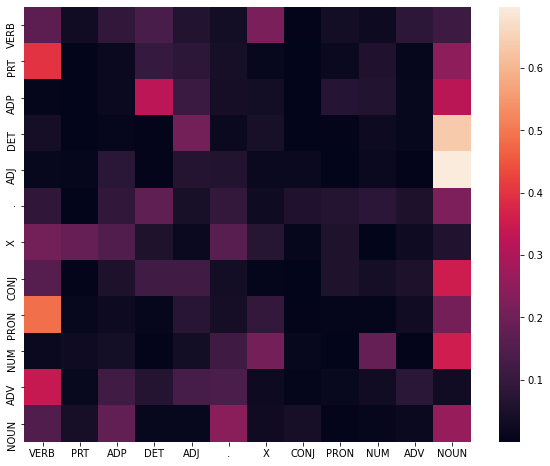

In [20]:
# heatmap of tags matrix
# T(i, j) indicates P(tag j given tag i)
plt.figure(figsize=(10, 8))
sns.heatmap(tags_df)
plt.show()

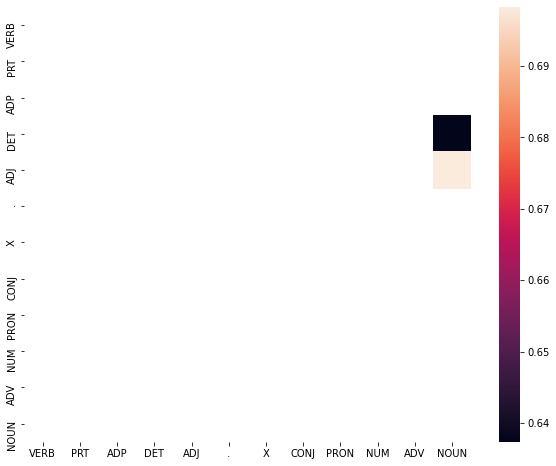

In [21]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(10, 8))
sns.heatmap(tags_frequent)
plt.show()

#### The probability of Nouns following determinants and adjectives is the highest.

#### Vanilla Viterbi Heuristic
#### Why does the Viterbi algorithm choose a random tag on encountering an unknown word? When the algorithm encounters an unknown word, it gets the count of it which is 0 and the emission probability becomes 0, which makes the state_probability 0. This is repeated for all the Tags for the unknown word and the max of this is 0. The index of the list that contains 0 is first and hence the first tag in T is picked always.

In [22]:
def Viterbi(words, train_bag = train_wordAndTag_list):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emissionNAndD = word_given_tag(words[key], tag)
            emission_p = emissionNAndD[0]/emissionNAndD[1]  
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [23]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset.
# Keep it to ~50 so that the entire file completes in 20 minutes. If its 196, which is the size of test data
# it takes around 

TEST_DATA_SIZE = 50 

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(TEST_DATA_SIZE)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]

print(test_run_base)
print()
print(test_tagged_words)

[('The', 'DET'), ('bank', 'NOUN'), ('stocks', 'NOUN'), ('got', 'VERB'), ('a', 'DET'), ('boost', 'NOUN'), ('when', 'ADV'), ('Connecticut', 'NOUN'), ('Bank', 'NOUN'), ('&', 'CONJ'), ('Trust', 'NOUN'), ('and', 'CONJ'), ('Bank', 'NOUN'), ('of', 'ADP'), ('New', 'NOUN'), ('England', 'NOUN'), ('said', 'VERB'), ('0', 'X'), ('they', 'PRON'), ('no', 'ADV'), ('longer', 'ADV'), ('oppose', 'VERB'), ('pending', 'VERB'), ('legislation', 'NOUN'), ('that', 'DET'), ('*T*-1', 'X'), ('would', 'VERB'), ('permit', 'VERB'), ('banks', 'NOUN'), ('from', 'ADP'), ('other', 'ADJ'), ('regions', 'NOUN'), ('to', 'PRT'), ('merge', 'VERB'), ('with', 'ADP'), ('Connecticut', 'NOUN'), ('and', 'CONJ'), ('Massachusetts', 'NOUN'), ('banks', 'NOUN'), ('*T*-2', 'X'), ('.', '.'), ('But', 'CONJ'), ('a', 'DET'), ('Soviet', 'ADJ'), ('bank', 'NOUN'), ('here', 'ADV'), ('would', 'VERB'), ('be', 'VERB'), ('crippled', 'VERB'), ('*-51', 'X'), ('unless', 'ADP'), ('Moscow', 'NOUN'), ('found', 'VERB'), ('a', 'DET'), ('way', 'NOUN'), ('0',

#### Tagging the test sentences by calling the Viterbi Heuristic Algo.

In [ ]:
def tagSentencesViterbi(words2BeTagged):
    start = time.time()
    tagged_seq = Viterbi(words2BeTagged)
    end = time.time()
    difference = end-start
    print("***Time taken to tag**** ", difference)
    return tagged_seq

tagged_seq = tagSentencesViterbi(test_tagged_words)

In [ ]:
#print(tagged_seq)
#print(test_run_base)

#### Check the accuracy of the Viterbi Algorithm by comparing the train data's built in tag values and the ones we generated

In [ ]:
# Util method to check the accuracy
def checkAccuracy(taggedWords, correctlyTaggedTestRun):
    check = [i for i, j in zip(taggedWords, correctlyTaggedTestRun) if i == j]
    accuracy = len(check)/len(taggedWords)
    return accuracy

plainViterbiAccuracy = checkAccuracy(tagged_seq, test_run_base)
print("*****Plain Viterbi Accuracy*****", plainViterbiAccuracy)

### Accuracy with vanilla Viterbi is 88.5% which is good.

In [ ]:
#k = zip(tagged_seq, test_run_base)
#print(list(k))


#### Find incorrectly tagged words along with the previous tag

In [ ]:
def findIncorrectlyTaggedWords(taggedWords, correctlyTaggedTestData):
    wrongTaggedWords = [[correctlyTaggedTestData[i-1],j] for i, j in enumerate(zip(taggedWords, correctlyTaggedTestData)) if j[0]!=j[1]]
    return wrongTaggedWords
    
wordsWithWrongTagsWithPreviousTag = findIncorrectlyTaggedWords(tagged_seq, test_run_base)
wordsWithWrongTagsWithPreviousTag

### Step 3. Move to Test_sentences.txt

In [ ]:
# Util to clean the lines
def getCleanedLinesFromTestData(file):
    lines = []
    f = codecs.open(file, encoding='utf-8')
    for line in f:
        if line.rstrip()!='':
            lines.append(line.rstrip())
    return lines
    
test_lines = getCleanedLinesFromTestData("Test_sentences.txt")
test_lines

In [ ]:
# Get the words
def getWordsFromLines(lines):
    words = []
    for line in lines:
        words.extend(word_tokenize(line))
    return words

words_from_test_lines = getWordsFromLines(test_lines)
print("**** All words from test lines ****\n", words_from_test_lines)

In [ ]:
wordsAndTags_from_test_lines = tagSentencesViterbi(words_from_test_lines)
print("\n****Words and tags from plain Viterbi*****\n", wordsAndTags_from_test_lines)

#### Get the list of unknown - alien words

In [ ]:
#Get the list of words which are present in test lines but not in the training corpus
words_not_in_corpus = list(set(words_from_test_lines) - set(tokens_set))
words_not_in_corpus

In [ ]:
# Concisely print the tags for alien words
def printTagsForAlienWords(alienWords, alienWordsWithTags):
    wrongTaggedWords = []
    wrongTaggedWords = [wordAndTag for wordAndTag in alienWordsWithTags if (wordAndTag[0] in set(alienWords))]
    return wrongTaggedWords

### Note that the default tag assigned to alien words is the one that occurs first in the Tag list. This will change for each run.

In [ ]:
alienWordsAndTags = printTagsForAlienWords(words_not_in_corpus, wordsAndTags_from_test_lines)
print("***Alien words and their tags***\n", alienWordsAndTags)

### Step 4. Solve the problem of unknown words. Which tag class do you think most unknown words belong to? Can you identify rules (e.g. based on morphological cues) that can be used to tag unknown words? When an alien word is encountered it must be a NOUN. This heuristic can be bluntly applied or we can use morphological forms of the word and identify it as an article, adjective, verb etc., We can even apply a simplified version of Laplace smoothening.

### Version 1 of Viterbi - Use regex and morphological forms to tag the unknown words.
### Specify patterns for tagging.
### Source - https://www.nltk.org/book/ch05.html.

In [ ]:

patterns = [
    #NUMBERS
    ("^-?[0-9]+(.[0-9]+)?$", 'NUM'),    
    
    #ADJECTIVES
    (".*able$", 'ADJ'),        
    
    #VERBS and variants
    (".*ing$", 'VERB'),      
    (".*ed$", 'VERB'),       
    (".*es$", 'VERB'),        
    (".*ould$", 'VERB'),      
    
    #ADVERB
    (".*ly$", 'ADV')
]

# If the whole word matches one of these we need to tag it as DET
def isDeterminant(text):
    if (text in set(['The', 'the', 'A', 'a', 'An', 'an'])):
        return True
    return False


# If we don't tag it as a DET, identify the patterns. If none matches, the tag must be NOUN.
def getStateForWord(text):
    state = ""
    if isDeterminant(text):
        return "DET"
    else:
        for pattern in patterns:
            if re.search(pattern[0], text):
                state = pattern[1]
                #print(pattern[0], "---", text, "---", state)
                return state
    return "NOUN"

In [ ]:
# Viterbi Heuristic
def ViterbiV2(words, train_bag = train_wordAndTag_list):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emissionNAndD = word_given_tag(words[key], tag)
            emission_p = emissionNAndD[0]/emissionNAndD[1]            
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        
        # If pmax is 0, get the most suitable tag by checking morphology
        # assign state_max
        # ELSE
        # If pmax is not 0, then proceed with 
        # getting state for which probability is maximum
        if pmax == 0:
            state_max = getStateForWord(words[key])
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
        
    return list(zip(words, state))

# tagging the test sentences
def tagSentencesViterbiV2(words2BeTagged):
    start = time.time()
    tagged_seq = ViterbiV2(words2BeTagged)
    end = time.time()
    difference = end-start
    print("***Time taken to tag**** ", difference)
    return tagged_seq



In [ ]:
temp_test_words = ['Android', 'is', 'a', 'mobile', 'operating', 'system', 'developed', 'by', 'Google', '.', 
                   'Android', 'has', 'been', 'the', 'best-selling', 'OS', 'worldwide', 'on', 'smartphones', 
                   'since', '2011', 'and', 'on', 'tablets', 'since', '2013', '.', 
                   'Google', 'and', 'Twitter', 'made', 'a', 'deal', 'in', '2015', 'that', 'gave', 'Google', 'access', 
                   'to', 'Twitter', "'s", 'firehose', '.']

wordsAndTags_from_test_lines = tagSentencesViterbiV2(temp_test_words)
print("****Words and tags from ViterbiV2*****\n", wordsAndTags_from_test_lines)

In [ ]:
tagged_seq_v2 = tagSentencesViterbiV2(test_tagged_words)
viterbiV2Accuracy = checkAccuracy(tagged_seq_v2, test_run_base)
print(viterbiV2Accuracy)

### Accuracy jumped to 94% which is better than vanilla Viterbi.

### Version 2 of Viterbi - Use a smoothening constant.
### Note that if the word is alien, the emission probability is 0. Its unfair to drag the state to 0 and hence to simulate 0 emission probability assign a value that is smaller than the probability of other words. It requires a bit of tuning to get good accuracy.

In [ ]:
# Viterbi Heuristic
SMOOTHENING_CONSTANT = 0.00001
def ViterbiV3(words, train_bag = train_wordAndTag_list):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                #print("**state[-1]** ", state[-1])
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emissionNAndD = word_given_tag(words[key], tag)
            emission_p = emissionNAndD[0]/emissionNAndD[1]  
            if emission_p == 0:
                emission_p = SMOOTHENING_CONSTANT
            
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))


# tagging the test sentences
def tagSentencesViterbiV3(words2BeTagged):
    start = time.time()
    tagged_seq = ViterbiV3(words2BeTagged)
    end = time.time()
    difference = end-start
    print("***Time taken to tag**** ", difference)
    return tagged_seq

In [ ]:
tagged_seq_v3 = tagSentencesViterbiV3(test_tagged_words)
viterbiV3Accuracy = checkAccuracy(tagged_seq_v3, test_run_base)
print(viterbiV3Accuracy)

### Accuracy is 91%, better than vanilla Viterbi but not as good as rule based.

### Version 3 of Viterbi - Assign the tag that occurs maximum in the training corpus.
### The tag that occurs maximum number of times in the training corpus is NOUN followed by VERB. We will assign NOUN as the tag for alien words. 

In [ ]:
# Viterbi Heuristic
def ViterbiV4(words, train_bag = train_wordAndTag_list):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emissionNAndD = word_given_tag(words[key], tag)
            emission_p = emissionNAndD[0]/emissionNAndD[1]            
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        
        # If pmax is 0, assign the tag that occurs most, which is NOUN
        # ELSE
        # If pmax is not 0, then proceed with 
        # getting state for which probability is maximum
        if pmax == 0:
            state_max = "NOUN"
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
        
    return list(zip(words, state))

# tagging the test sentences
def tagSentencesViterbiV4(words2BeTagged):
    start = time.time()
    tagged_seq = ViterbiV4(words2BeTagged)
    end = time.time()
    difference = end-start
    print("***Time taken to tag**** ", difference)
    return tagged_seq

In [ ]:
tagged_seq_v4 = tagSentencesViterbiV4(test_tagged_words)
viterbiV4Accuracy = checkAccuracy(tagged_seq_v4, test_run_base)
print(viterbiV4Accuracy)

### Accuracy is 93% comparable to rule based. Even this is a rule based algorithm.

### Step 5. Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

### From the Test_sentences.txt, we pick 3 sentences, and apply the 4 versions of the Viterbi Algorithm and check which one did well.

### Pick 3 sentences

In [ ]:
words_in_test_sentences = [ 
'Android', 'has', 'been', 'the', 'best-selling', 'OS', 'worldwide', 'on', 'smartphones', 'since', '2011', 'and', 'on', 
'tablets', 'since', '2013', '.', 
'Google', 'and', 'Twitter', 'made', 'a', 'deal', 'in', '2015', 'that', 'gave', 'Google', 'access', 'to', 
'Twitter', "'s", 'firehose', '.', 
'Twitter', 'is', 'an', 'online', 'news', 'and', 'social', 'networking', 'service', 'on', 'which', 'users', 
'post', 'and', 'interact', 'with', 'messages', 'known', 'as', 'tweets', '.',
]

### Vanilla Viterbi - Alien words are tagged wrong.

In [ ]:
tagged_words_Run1 = tagSentencesViterbi(words_in_test_sentences)
print(tagged_words_Run1)

### Viterbi with regex and modified forms - Alien words are tagged close to reality.
#### Most of the nouns are tagged right, except smartphones.

In [ ]:
tagged_words_Run2 = tagSentencesViterbiV2(words_in_test_sentences)
print(tagged_words_Run2)

### Viterbi with laplace smoothening - Alien words are tagged second best to regex and modified form Viterbi.
#### A few numbers are tagged wrong.

In [ ]:
tagged_words_Run3 = tagSentencesViterbiV3(words_in_test_sentences)
print(tagged_words_Run3)

### Viterbi with NOUN tagging for all aliens - Performs worst of all 3 Viterbis.
#### Note that all the alien words are tagged NOUNS, which reduces accuracy.

In [ ]:
tagged_words_Run4 = tagSentencesViterbiV4(words_in_test_sentences)
print(tagged_words_Run4)

#### END OF SOLUTION